# IMPORTS

In [1]:
## Work with arrays
import numpy as np
## Make figures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as mticker
## Draw maps
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LatitudeLocator, LongitudeLocator
# Open netCDF-files
import netCDF4 as nc
# Manipulate data-frames
import pandas as pd
# Manipulate dates
import datetime as dt
from dateutil.relativedelta import relativedelta

from data_path import DATA_PATH_SROK8C

# CATALOG

In [2]:
stations = pd.read_csv(DATA_PATH_SROK8C+"../catalog.csv")
stations

,Индекс ВМО,Наименование станции,Широта,Долгота,Высота,Начало наблюдений,Примечание
0,20046,Им.Э.Т.Кренкеля,80°37',58°03',21,1966,NaN
1,20069,Остров Визе,79°30',76°59',12,1966,NaN
2,20087,Им.Г.А.Ушакова (Голомянный),79°33',90°37',7,1966,До 2015г. наз. Остров Голомянный
3,20107,Баренцбург,78°04',14°15',73,1966,NaN
4,20289,Русский,77°10',96°26',9,1966,Закрыта в 1999г.
...,...,...,...,...,...,...,...
516,37461,"Сулак, высокогорная",42°22',46°15',2927,1966,NaN
517,37470,Дербент,42°04',48°18',-19,1966,NaN
518,37471,Буйнакск,42°49',47°07',472,1966,NaN
519,37472,Махачкала,43°01',47°29',-20,1966,"С 1966г. по 11.1991г. – Махачкала,АЭ, ЮВ окраи..."


In [3]:
def converter(geoCoord: str):
    delimiter = geoCoord.find("°")
    if delimiter == -1:
        delimiter = geoCoord.find("о")
    if delimiter == -1:
        delimiter = geoCoord.find("o")
    return float(geoCoord[:delimiter]) + float(geoCoord[delimiter+1:delimiter+3])/60

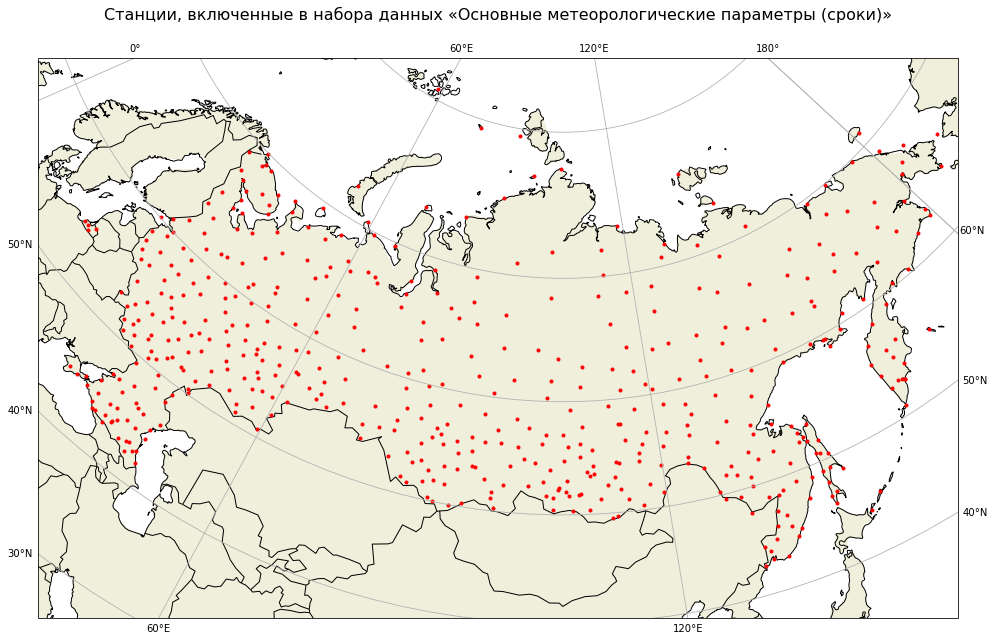

In [4]:
locs = np.empty((520,2))
for i in range(520):
    locs[i,0] = converter(stations["Широта"][i])
    locs[i,1] = converter(stations["Долгота"][i])   

fig = plt.figure(figsize=(16,9), layout='tight')
lambert_crs = ccrs.LambertConformal(central_longitude=105) 
ax = fig.add_subplot(1,1,1,
                     projection=lambert_crs
                    )
ax.set_extent(
    [35, 155, 40, 80], 
    crs=ccrs.PlateCarree()
)
gl = ax.gridlines(
    draw_labels=True, 
    dms=True, 
    x_inline=False,
    y_inline=False
)
gl.rotate_labels = False
ax.coastlines(resolution='50m')
for loc in locs:
    plt.plot(
        loc[1], loc[0], 
        transform=ccrs.PlateCarree(),
        marker='.', color='red'
    )
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.set_title("Станции, включенные в набора данных «Основные метеорологические параметры (сроки)»\n", fontsize=16)
fig.savefig("rihmi_wdc_stations.png", dpi=250)

# PARAMETERS EXTRACTION

In [10]:
VALID_QUALITIES = [0, 1, 2]

def dfFromSrok8cDatFile(stationSynopticIndex: int):
    d = {
        "GMT datetime" : list(),
        "Horizontal visibility (km)" : list(),
        "Total cloudiness (points)" : list(),
        "Amount of low-level clouds (points)" : list(),
        "Shape of upper-level clouds" : list(),
        "Shape of middle-level clouds" : list(),
        "Shape of vertical development clouds" : list(),
        "Stratus and stratocumulus" : list(),
        "Nimbostratus and fracto-nimbus" : list(),
        "Cloud ceiling (m)" : list(),
        "Weather between observation hours" : list(),
        "Weather during observation hour" : list(),
        "Wind direction (degrees)" : list(),
        "Wind speed (m/s)" : list(),
        "Maximum wind speed (m/s)" : list(),
        "Precipitation total in the period between observation hours (mm)" : list(),
        "Soil surface temperature (°C)" : list(),
        "Minimum soil surface temperature (°C)" : list(),
        "Minimum soil surface temperature between observation hours (°C)" : list(),
        "Maximum soil surface temperature between observation hours (°C)" : list(),
        "Maximum thermometer temperature of soil surface (°C)" : list(),
        "Dry-bulb thermometer air temperature (°C)" : list(),
        "Wet-bulb thermometer air temperature (°C)" : list(),
        "Minimum air temperature between observation hours (°C)" : list(),
        "Maximum air temperature between observation hours (°C)" : list(),
        "Maximum thermometer air temperature (°C)" : list(),
        "Water vapour partial pressure (mbar)" : list(),
        "Relative air humidity (%)" : list(),
        "Water vapour saturation deficit (mbar)" : list(),
        "Dew point temperature (°C)" : list(),
        "Air pressure at station level (mbar)" : list(),
        "Air pressure at sea level (mbar)" : list(),
        "Characteristic of baric tendency" : list(),
        "Pressure tendency value (mbar)" : list()
    }
    
    with open(
        DATA_PATH_SROK8C
        + f"{stationSynopticIndex}.dat"
    ) as f:
        for line in f:
            # 0:4
            d["GMT datetime"] += [
                dt.datetime(
                    int(line[6:10]), 
                    int(line[11:13]), 
                    int(line[14:16]),
                    int(line[17:19])
                )
            ]
            # 20:24 Year of source (local)
            # 25:27 Month of source (local)
            # 28:30 Day of source (local)
            # 31:33 Hour of source
            # 34:36 Number of hour in a day according to standard winter decree time (SWDT)
            # 37:39 Local time
            timeZone = int(line[40:42])
            # 43:45 Meteorological day onset (SWDT)
            code = line[46:48]
            quality = int(line[49:50])
            idGT = line[51:52]
            d["Horizontal visibility (km)"] += [hrzVsbltInKm(code, quality, idGT)]
            code = line[53:55]
            quality = int(line[56:57])
            d["Total cloudiness (points)"] += [cldnssInPoints(code, quality)]
            code = line[58:60]
            quality = int(line[61:62])
            d["Amount of low-level clouds (points)"] += [cldnssInPoints(code, quality)]
            code = line[63:65]
            quality = int(line[66:67])
            d["Shape of upper-level clouds"] += [shpCld(code, quality)]
            code = line[68:70]
            quality = int(line[71:72])
            d["Shape of middle-level clouds"] += [shpCld(code, quality)]
            code = line[73:75]
            quality = int(line[76:77])
            d["Shape of vertical development clouds"] += [shpCld(code, quality)]
            code = line[78:80]
            quality = int(line[81:82])
            d["Stratus and stratocumulus"] += [shpCld(code, quality)]
            code = line[83:85]
            quality = int(line[86:87])
            d["Nimbostratus and fracto-nimbus"] += [shpCld(code, quality)]
            code = line[88:92]
            quality = int(line[93:94])
            method = line[95:96]
            d["Cloud ceiling (m)"] += [cldClng(code, quality, method)]
            # 97:99
            # 100:101
            code = line[102:104]
            quality = int(line[105:106])
            d["Weather between observation hours"] += [wthr(code, quality)]
            code = line[107:109]
            quality = int(line[110:111])
            d["Weather during observation hour"] += [wthr(code, quality)]
            code = line[112:115]
            quality = int(line[116:117])
            d["Wind direction (degrees)"] += [windDir(code, quality)]
            code = line[118:120]
            quality = int(line[121:122])
            idGT = line[123:124]
            d["Wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            code = line[125:127]
            quality = int(line[128:129])
            idGT = line[130:131]
            d["Maximum wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            code = line[132:138]
            quality = int(line[139:140])
            d["Precipitation total in the period between observation hours (mm)"] += [
                precip(code, quality)
            ]
            code = line[141:146]
            quality = int(line[147:148])
            d["Soil surface temperature (°C)"] += [temp(code, quality)]
            code = line[149:154]
            quality = int(line[155:156])
            d["Minimum soil surface temperature (°C)"] += [temp(code, quality)]
            code = line[157:162]
            quality = int(line[163:164])
            d["Minimum soil surface temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[165:170]
            quality = int(line[171:172])
            d["Maximum soil surface temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[173:178]
            quality = int(line[179:180])
            d["Maximum thermometer temperature of soil surface (°C)"] += [
                temp(code, quality)
            ]
            code = line[181:186]
            quality = int(line[187:188])
            d["Dry-bulb thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[189:194]
            quality = int(line[195:196])
            d["Wet-bulb thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            # 197:198 Identifier of ice on the lawn
            # 199:204 Minimum alcohol thermometer air temperature
            # 205:206 Quality flag
            code = line[207:212]
            quality = int(line[213:214])
            d["Minimum air temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[215:220]
            quality = int(line[221:222])
            d["Maximum air temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[223:228]
            quality = int(line[229:230])
            d["Maximum thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[231:236]
            quality = int(line[237:238])
            prec = line[239:240]
            d["Water vapour partial pressure (mbar)"] += [prs(code, quality, prec)]
            code = line[241:244]
            quality = int(line[245:246])
            d["Relative air humidity (%)"] += [rh(code, quality)]
            code = line[247:254]
            quality = int(line[255:256])
            prec = line[257:258]
            d["Water vapour saturation deficit (mbar)"] += [dfct(code, quality, prec)]
            code = line[259:264]
            quality = int(line[265:266])
            d["Dew point temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[267:273]
            quality = int(line[274:275])
            prec = "1"
            d["Air pressure at station level (mbar)"] += [prs(code, quality, prec)]
            code = line[276:282]
            quality = int(line[283:284])
            prec = "1"
            d["Air pressure at sea level (mbar)"] += [prs(code, quality, prec)]
            code = line[285:287]
            quality = int(line[288:289])
            d["Characteristic of baric tendency"] += [chrctrstcBrcTndnc(code, quality)]
            code = line[290:294]
            quality = int(line[295:296])
            d["Pressure tendency value (mbar)"] += [prssrTndncVal(code, quality)]
    d['Precipitation rate (mm/s)'] = list(
        precipRate(
            d[
                "Precipitation total in the period between observation hours (mm)"
            ]
        ) / (3 * 3600)
    )
    df = pd.DataFrame(data=d)
    return df

def precipRate(a):
    FILL_VALUE = -999.0
    res = np.zeros_like(a)
    i0 = 0
    i1 = i0 + 1
    for i, aa in enumerate(a[1:]):
        if aa == FILL_VALUE:
            i1 += 1
        else:
            res[i0:i1] = aa / (i1 - i0)
            i0 = i
            i1 = i0 + 1
    return res

def prssrTndncVal(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def chrctrstcBrcTndnc(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res             
            
def dfct(code: str, quality: int, prec: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
    return res
            
def rh(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def prs(code: str, quality: int, prec: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
    return res

def temp(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res            
            
def precip(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res

def windSpd(code: str, quality: int, idGT: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES and idGT == "0":
        res = float(code)
    return res
            
def windDir(code: str, quality: int) -> float:
    NO_WIND = -999.0
    DIFF_DIRS = -999.0
    res = -999.0
    if quality in VALID_QUALITIES:
        if int(code) > 0 and int(code) <= 360:
            res = float(code)
        elif int(code) == 0:
            res = NO_WIND
        elif int(code) == 999:
            res = DIFF_DIRS
    return res    

def wthr(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res                
            
def cldClng(code: str, quality: int, method: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES and code != "    ":
        res = float(code)
    return res

def shpCld(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res    
    
def cldnssInPoints(code: str, quality: int) -> float:
    CLDNSS_11 = -999.0 #11
    CLDNSS_12 = -999.0 #12
    CLDNSS_13 = -999.0 #13
    res = -999.0
    if quality in VALID_QUALITIES and code != "99":
        if code == "11":
            res = CLDNSS_11
        elif code == "12":
            res = CLDNSS_12
        elif code == "13":
            res = CLDNSS_13
        else:
            res = float(code)
    return res        

def hrzVsbltInKm(code: str, quality: int, idGT: str) -> float:
    LT_01KM = -999.0 #0.1 * (1.0 - 0.5)
    LT_005KM = -999.0 #0.05 * (1.0 - 0.5)
    GT_70KM = -999.0 #70.0 * (1.0 + 0.5)
    GT_50KM = -999.0 #50.0 * (1.0 + 0.5)
    res = -999.0
    if quality in VALID_QUALITIES and idGT == " ":
        if code == "00":
            res = LT_01KM
        elif code in genCodes(1, 50+1):
            res = float(int(code)) / 10.0
        elif code in genCodes(56, 80+1):
            res = float(code) - 50.0
        elif code in genCodes(81, 88+1):
            res = (float(code) - 76.0) * 5.0
        elif code == "89":
            res = GT_70KM
        elif code == "90":
            res = LT_005KM
        elif code == "91":
            res = 0.05
        elif code == "92":
            res = 0.2
        elif code == "93":
            res = 0.3
        elif code == "94":
            res = 1.0
        elif code == "95":
            res = 2.0
        elif code == "96":
            res = 4.0
        elif code == "97":
            res = 10.0
        elif code == "98":
            res = 20.0
        elif code == "99":
            res = GT_50KM    
    return res

def genCodes(start, end):
    res = list()
    if end > 99:
        return -999.0
    for i in range(start, end):
        if i < 10:
            res += [f"0{i}"]
        else:
            res += [f"{i}"]
    return res

# STATIONS WITH VALID DATA

In [34]:
COLUMNS = [
    'GMT datetime', 
#     'Total cloudiness (points)', 
#     'Wind speed (m/s)',
#     'Precipitation rate (mm/s)',
    # 'Soil surface temperature (°C)',
#     'Dry-bulb thermometer air temperature (°C)',
    'Water vapour partial pressure (mbar)',
    'Relative air humidity (%)',
#     'Air pressure at station level (mbar)',
]

def frOfValidHours(stationSynopticIndex: int):
    df = dfFromSrok8cDatFile(stationSynopticIndex)[COLUMNS]
    len0 = len(df)
    # Exclude measurements with missing values
    for column in COLUMNS[1:]:
        df = df[df[column]>-999]
    len1 = len(df)
    return len1/len0

In [7]:
files = !!(ls $DATA_PATH_SROK8C)
indices = [int(file[:-4]) for file in files]
indices[:10]
# for i in indices:
#     print(i, frOfValidHours(i))

[20046, 20069, 20087, 20107, 20289, 20292, 20476, 20667, 20674, 20744]

In [9]:
0.95 * (105 - 5.67e-8 * 265**4)

-165.88797441562497

In [35]:
df = dfFromSrok8cDatFile(indices[0])

In [36]:
df[COLUMNS][:100]

,GMT datetime,Water vapour partial pressure (mbar),Relative air humidity (%)
0,1965-12-31 18:00:00,-999.0,79.0
1,1965-12-31 21:00:00,-999.0,79.0
2,1966-01-01 00:00:00,-999.0,78.0
3,1966-01-01 03:00:00,-999.0,77.0
4,1966-01-01 06:00:00,-999.0,77.0
...,...,...,...
95,1966-01-12 15:00:00,-999.0,85.0
96,1966-01-12 18:00:00,-999.0,89.0
97,1966-01-12 21:00:00,-999.0,89.0
98,1966-01-13 00:00:00,-999.0,90.0


In [37]:
for col in COLUMNS[1:]:
    print(col + " : ", len(df[df[col] > -999]) / len(df))

Water vapour partial pressure (mbar) :  0.7067522455449349
Relative air humidity (%) :  0.8818026802440079


In [14]:
df_ = df.copy()
for col in COLUMNS[1:]:
    df_ = df_[df_[col] > -999]
df_ = df_[COLUMNS]

In [15]:
len(df_) / len(df)

0.8135777414861425

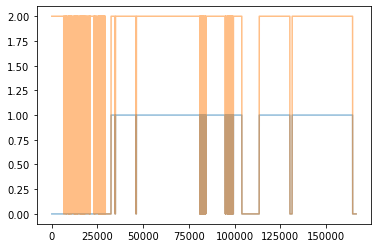

In [39]:
i = 0
for col in COLUMNS[1:]:
    i += 1
    plt.plot((df[col]>-999) * i, alpha=0.5)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


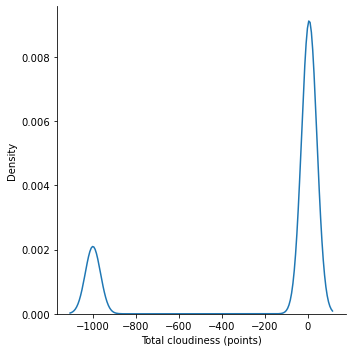

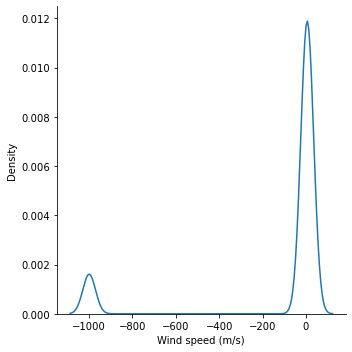

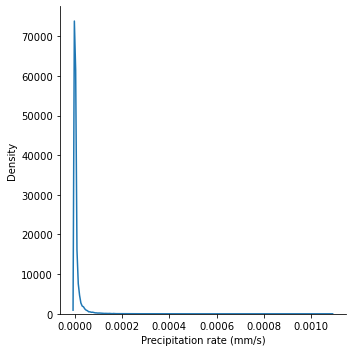

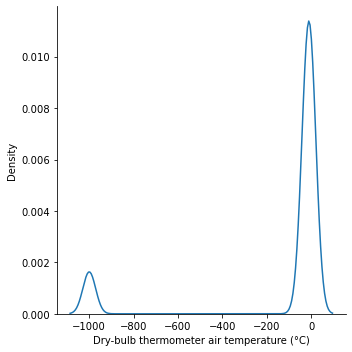

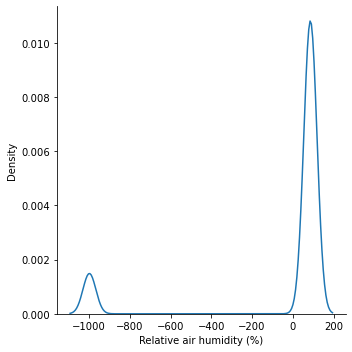

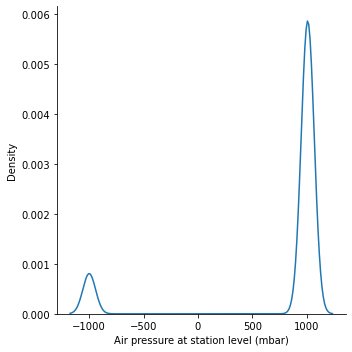

In [32]:
for col in COLUMNS[1:]:
    _ = sns.displot(df, x=col, kind="kde")